# Analyzing Feasibility of COVID-19 Isolation Across US Western States Pact Metropolitan Areas

In [249]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('fivethirtyeight')

The data files are imported 2015 American Housing Survey Public Use Flat Files from Census.gov including the National Public Use File (ahs2015n.csv) and Metropolitan Public Use File (ahs2015m.csv) downloaded from https://www.census.gov/programs-surveys/ahs/data/2015/ahs-2015-public-use-file--puf-.html To allow the descriptive labels to be automatically applied to each column as needed, I also imported a separate labels table from the AHS 2015 Value Labels.csv to allow the proper labeling of axes using a data dictionary.

To allow conversion of OMB13CBSA numerical codes to their descriptive metropolitan labels, I imported a code crosswalk from https://public.opendatasoft.com/explore/dataset/core-based-statistical-areas-cbsas-and-combined-statistical-areas-csas/download/?format=xls&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true as the codeset maintained by the OMB is only available as a PDF file.

The COVID-19 case data is from USAFacts.org which is a non-profit organization that consolidates and standardizes official US government data. This dataset uniquely takes the more typical state, county or city level data and includes FIPS county codes to allow easy mapping to the CBSA metropolitan areas used by the Census Bureau. This eliminates possible data issues like the commonality of county names like Washington County (31 nationally), Jefferson County (26 nationally), and Franklin County (25 nationally).

To improve performance, I only want to import the columns needed in this data analysis instead of the entire 2995 available.

In [250]:
columns=['CONTROL', 'OMB13CBSA', 'VACANCY', 'BLD', 'UNITSIZE', 'TOTROOMS', 'BEDROOMS',
         'BATHROOMS', 'HSHLDTYPE', 'NUMPEOPLE', 'NUMADULTS', 'NUMELDERS', 'NUMYNGKIDS', 'NUMOLDKIDS',
         'NUMVETS', 'NUMNONREL', 'MULTIGEN', 'GRANDHH', 'NUMSUBFAM', 'NUMSECFAM', 'DISHH', 
         'WASHER', 'DRYER', 'FRIDGE', 'COOKTYPE', 'KITEXCLU', 'BATHEXCLU']

In [251]:
ahs_n=pd.read_csv('data/ahs2015n.csv', usecols=columns)
ahs_m=pd.read_csv('data/ahs2015m.csv', usecols=columns)
cbsa=pd.read_csv('data/cbsa.csv', dtype=str)
labels=pd.read_csv('data/AHS 2015 Value Labels.csv')
covid=pd.read_csv('data/covid_confirmed_usafacts.csv', dtype=str)

Verify the file imports:

In [252]:
ahs_n.shape

(69493, 27)

In [253]:
ahs_m.shape

(24886, 27)

In [254]:
cbsa.shape

(1918, 12)

In [255]:
labels.shape

(11121, 8)

In [256]:
covid.shape

(3193, 507)

For ease of analysis of the AHS data, I will append the national dataset and the metropolitan dataset.

In [257]:
ahs=ahs_n.append(ahs_m)
ahs.shape
ahs.columns
ahs.set_index('CONTROL', inplace=True)
ahs.index.name
ahs['OMB13CBSA'].unique()
ahs.isnull().sum()

TOTROOMS      0
OMB13CBSA     0
BLD           0
HSHLDTYPE     0
NUMELDERS     0
NUMADULTS     0
NUMNONREL     0
NUMVETS       0
NUMYNGKIDS    0
NUMOLDKIDS    0
NUMSUBFAM     0
NUMSECFAM     0
NUMPEOPLE     0
GRANDHH       0
MULTIGEN      0
UNITSIZE      0
BEDROOMS      0
BATHEXCLU     0
KITEXCLU      0
FRIDGE        0
WASHER        0
COOKTYPE      0
DRYER         0
DISHH         0
BATHROOMS     0
VACANCY       0
dtype: int64

Cleaning up data to remove all quotation marks from AHS

In [258]:
ahs=ahs.applymap(lambda x: x.replace("'", "") if (isinstance(x, str)) else x)

Cleaning BATHROOMS column to remove leading zeros in data and converting to integer that are problematic for data analysis.

In [259]:
ahs['BATHROOMS_NUM']=ahs['BATHROOMS'].apply(pd.to_numeric)
ahs['WASHER']=ahs['WASHER'].apply(pd.to_numeric)
ahs['DRYER']=ahs['DRYER'].apply(pd.to_numeric)
ahs['FRIDGE']=ahs['FRIDGE'].apply(pd.to_numeric)
ahs['COOKTYPE']=ahs['COOKTYPE'].apply(pd.to_numeric)
ahs['DISHH']=ahs['DISHH'].apply(pd.to_numeric)
ahs['BATHEXCLU'].value_counts()

-6    94181
1        88
2        71
-9       39
Name: BATHEXCLU, dtype: int64

Now create a new boolean column Adequate_Bath that validates whether the household has enough bathrooms to dedicate one solely to the resident in isolation. The Census Bureau uses the value -6 to flag a vacant unit in the American Housing Survey, therefore negative values in the NUMPEOPLE column should be treated as if they were zero or null values. Public health authorities do not have any overcrowding definitions to bathroom usage, therefore the calculation is whether the household has more than one resident and if so, there is at least a half or full bath that can be solely dedicated to the use of the isolated resident. The Census codes the responses as :

| AHS 2015 Variable Value |  Descriptive Label|
| :--- | :--- |
|1	    |One full bathroom |
|2	    |1.5 bathrooms|
|3	    |2 bathrooms|
|4	   | 2.5 bathrooms|
|5	   | 3 bathrooms|
|6	   | More than 3 bathrooms|
|7	    |No full bath: sink and tub present|
|8	    |No full bath: sink and toilet present|
|9	    |No full bath: tub and toilet present|
|10	    |No full bath: sink only|
|11	    |No full bath: tub only|
|12	    |No full bath: toilet only|
|13	    |No full bath: no sink, tub or toilet|

Therefore, values of 1-6 are adequate for single person households and values of 2-6 are adequate for multi-person households. The Census Bureau also verifies whether a bathoom is for the exclusive use of the household with the possible answers coded as:

| AHS 2015 Variable Value |  Descriptive Label | Numerical Conversion|
| :--- | :--- |:--- |
| 1	|Bathroom is outside unit but inside building| 1 |
| 2	|Bathroom is outside building| 2 |
| M	|Not reported| -9 |
| N	|Not applicable| -6 |

While this applies to a very small subset of housing units (159 units) out of the total sample of 94379 housing units or a mere 0.1685% of households, the non-exclusive use of a bathroom in the most affordable units like single-room occupancy hotels makes COVID-19 isolation impossible.

In [260]:
ahs.BATHEXCLU.value_counts()

-6    94181
1        88
2        71
-9       39
Name: BATHEXCLU, dtype: int64

In [261]:
def Adequate_Bath(row):
    if(row['BATHEXCLU']!=1 and row['BATHEXCLU']!=2):
        if(row['NUMPEOPLE']<=1):
            if(row['BATHROOMS_NUM']>=1 and row['BATHROOMS_NUM']<=6):
                return True
            else:
                return False
        elif(row['BATHROOMS_NUM']>=2 and row['BATHROOMS_NUM']<=6):
            return True
        else:
            return False
    else:
        return False

Applying the function to the AHS dataset...

In [262]:
ahs['ADQ_BATH']=ahs.apply(lambda row: Adequate_Bath(row), axis=1)
ahs[['NUMPEOPLE', 'BATHROOMS','BATHROOMS_NUM', 'BATHEXCLU', 'ADQ_BATH']].head(5)

,NUMPEOPLE,BATHROOMS,BATHROOMS_NUM,BATHEXCLU,ADQ_BATH
CONTROL,,,,,
'11000001',3,04,4,-6,True
'11000002',2,04,4,-6,True
'11000003',3,01,1,-6,False
'11000005',3,05,5,-6,True
'11000006',3,03,3,-6,True


Now create a new boolean column Adequate_Bedrooms that validates whether the household has enough bedrooms to dedicate one solely to the resident in isolation. Public health authorities define adequate bedrooms as, "Enough bedrooms is defined as a two- or three-person household having at least 2 bedrooms, and a household of four or more having enough bedrooms to allow one person to isolate in a bedroom without forcing three or more people in the household to share a remaining bedroom." The Census Bureau uses the value -6 to flag a vacant unit in the American Housing Survey, therefore negative values in the NUMPEOPLE column should be treated as if they were zero or null values.

In [263]:
def Adequate_Bed(row):
    if(row['NUMPEOPLE']<=1):
        return True
    elif(row['NUMPEOPLE']==2 or row['NUMPEOPLE']==3):
        if(row['BEDROOMS']>=2):
            return True
        else:
            return False    
    elif(row['NUMPEOPLE']>=4):
        if(((row['BEDROOMS']-1)/(row['NUMPEOPLE']-1)>=0.5)):
            return True
        else:
            return False
    else:
        return False

Now run through test cases to ensure the function is performing as intended:

In [264]:
ahs['ADQ_BED']=ahs.apply(lambda row: Adequate_Bed(row), axis=1)

Finally, we can determine whether a household can maintain an effective COVID-19 quarantine by whether they have both enough bedrooms and at least two full bathroom to keep one person completely isolated for the public health required isolation period. Households unable to maintain an effective COVID-19 quarantine are far more like to experience the spread of infection of other household members.

In [265]:
def Adequate_QUAR(row):
    if(row['ADQ_BED'] and row['ADQ_BATH']):
        return True
    else:
        return False

In [266]:
ahs['ADQ_QUAR']=ahs.apply(lambda row: Adequate_QUAR(row), axis=1)

Possible risk factors that increase the number of trips outside the home or make it more difficult to maintain self-isolation are laundry and kitchen facilities. If a household must use washers and dryers outside the home to do laundry or lacks the appliances of a full kitchen, the household must both make many more trips outside the home and spend more time in congregate public areas with other households. The WASHER data is coded with 1 equals Yes (there is a working washer) and 2 equals No (there is not a working washer). The DRYER data is coded with 1-4 representing a working clothes dryer and 5 as no working clothes dryer.

|AHS 2015 Value | Variable Label|
| :--- | :--- |
|1	|Working electric power clothes dryer
|2	|Working piped gas powered clothes dryer
|3	|Working LP (liquefied petroleum) gas clothes dryer
|4	|Working other fuel source powered clothes dryer
|5	|Unit does not have a working clothes dryer

In [267]:
def Laundry(row):
    if(row['WASHER']==2 or row['DRYER']==5):
        return False
    if(row['WASHER']==1):
        if(row['DRYER']>=1 and row['DRYER']<=4): 
            return True
        else:
            return False
    else:
        return False

In [268]:
ahs['ADQ_LAUNDRY']=ahs.apply(lambda row: Laundry(row), axis=1)

Full kitchen facilities allow households to maintain quarantine for longer periods of time safely. Without a working refrigerator, food safety requires shopping a minimum of every 48 to 72 hours even with the use of coolers to maintain food safety and freshness. Similarly, the lack of a full working stove with burners and oven allow the household to cook a full range of health foods from scratch rather than relying solely on a microwave to heat expensive and nutritionally poor convenience foods. The AHS Survey documents both the availabilty of a refrigerator using the FRIDGE column (1=Yes, 2=No) and the cooking facilities available for heating food as documented below. In the table below of the COOKTYPE variable labels, a value of 1 documents the full use of a stove, while 2-4 document varying degrees of substandard cooking facilities that would make it difficult to maintain a full quarantine period without multiple trips for groceries or food deliveries.

|AHS 2015 COOKTYPE Variable Value | Descriptive  Label|
| :--- | :--- |
|1	|Cooking stove or range with oven, in working order |
|2	|Built-in cooking burners, no oven in working order |
|3	|Has microwave, but no oven or burners |
|4	|No working cooking equipment|

While this applies to a small subset of housing units (835 units) out of the total sample of 94379 housing units or 0.8847% of households, the non-exclusive use of a kitchen in more affordable units like single-room occupancy hotels makes COVID-19 isolation impossible.

In [269]:
ahs['KITEXCLU'].value_counts()

-6    69200
1     24344
2       835
Name: KITEXCLU, dtype: int64

In [270]:
def FULL_KITCHEN(row):
    if(row['KITEXCLU']!=2):
        if(row['FRIDGE']==1):
            if(row['COOKTYPE']==1):
                return True
            return False
        else:
            return False
    else:
        return False

In [271]:
ahs['ADQ_KITCHEN']=ahs.apply(lambda row: FULL_KITCHEN(row), axis=1)

In [272]:
ahs[['NUMPEOPLE','ADQ_BATH', 'ADQ_BED', 'ADQ_QUAR', 'ADQ_LAUNDRY', 'FRIDGE', 'COOKTYPE', 'KITEXCLU', 'ADQ_KITCHEN']].head(5)

,NUMPEOPLE,ADQ_BATH,ADQ_BED,ADQ_QUAR,ADQ_LAUNDRY,FRIDGE,COOKTYPE,KITEXCLU,ADQ_KITCHEN
CONTROL,,,,,,,,,
'11000001',3,True,True,True,True,1,1,-6,True
'11000002',2,True,True,True,True,1,1,-6,True
'11000003',3,False,True,False,True,1,1,-6,True
'11000005',3,True,True,True,True,1,1,-6,True
'11000006',3,True,True,True,True,1,1,-6,True


To allow labeling of the data with the assigned metropolitan area, we can join the AHS table with the CBSA using the common OMB13CBSA / CBSA Code fields.

In [273]:
ahs_label=pd.merge(ahs, cbsa, left_on='OMB13CBSA', right_on='CBSA Code' )

In [274]:
Table_1=pd.DataFrame(ahs_label.groupby('CBSA Title', as_index=True)['ADQ_QUAR'].agg(['mean']).sort_values('mean', ascending=True))
Table_1.rename(columns={ 'mean': 'Bed & Bath' }, inplace=True)
#print(Table_1)
Table_2=pd.DataFrame(ahs_label.groupby('CBSA Title', as_index=True)['ADQ_LAUNDRY'].agg(['mean']).sort_values('mean', ascending=True))                
Table_2.rename(columns={ 'mean': 'Laundry' }, inplace=True)
#print(Table_2)
Table_3=pd.DataFrame(ahs_label.groupby('CBSA Title', as_index=True)['ADQ_KITCHEN'].agg(['mean']).sort_values('mean', ascending=True))
Table_3.rename(columns={ 'mean': 'Kitchen' }, inplace=True)
#print(Table_3)

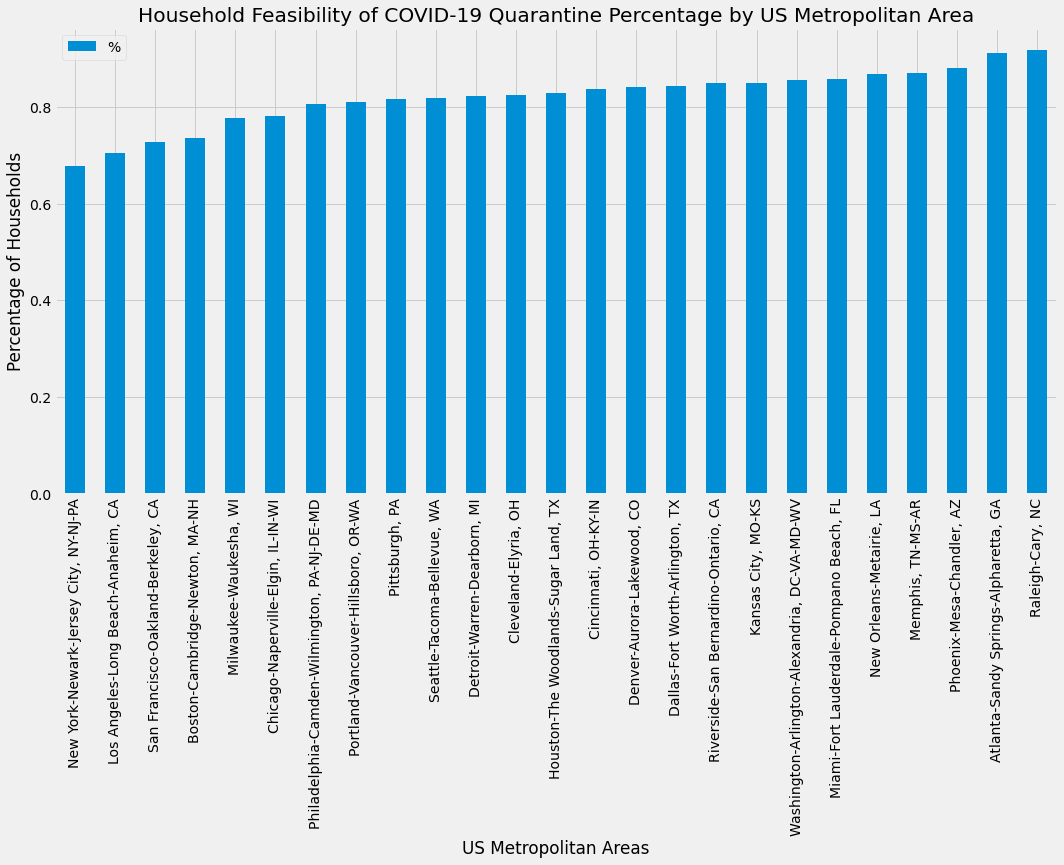

In [275]:
Table_1.plot(kind='bar', figsize=(16,8))
plt.legend('%')
plt.ylabel('Percentage of Households')
plt.xlabel('US Metropolitan Areas', )
plt.title("Household Feasibility of COVID-19 Quarantine Percentage by US Metropolitan Area");

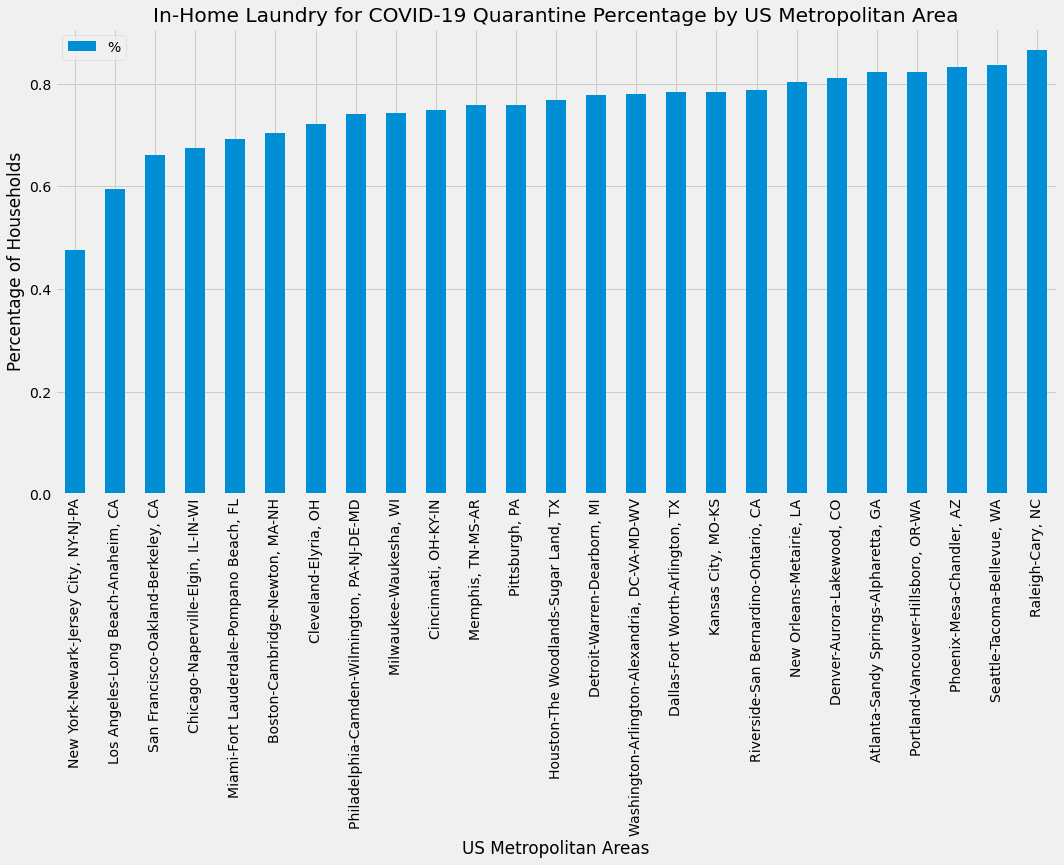

In [276]:
Table_2.plot(kind='bar', figsize=(16,8))
plt.legend('%')
plt.ylabel('Percentage of Households')
plt.xlabel('US Metropolitan Areas', )
plt.title("In-Home Laundry for COVID-19 Quarantine Percentage by US Metropolitan Area");

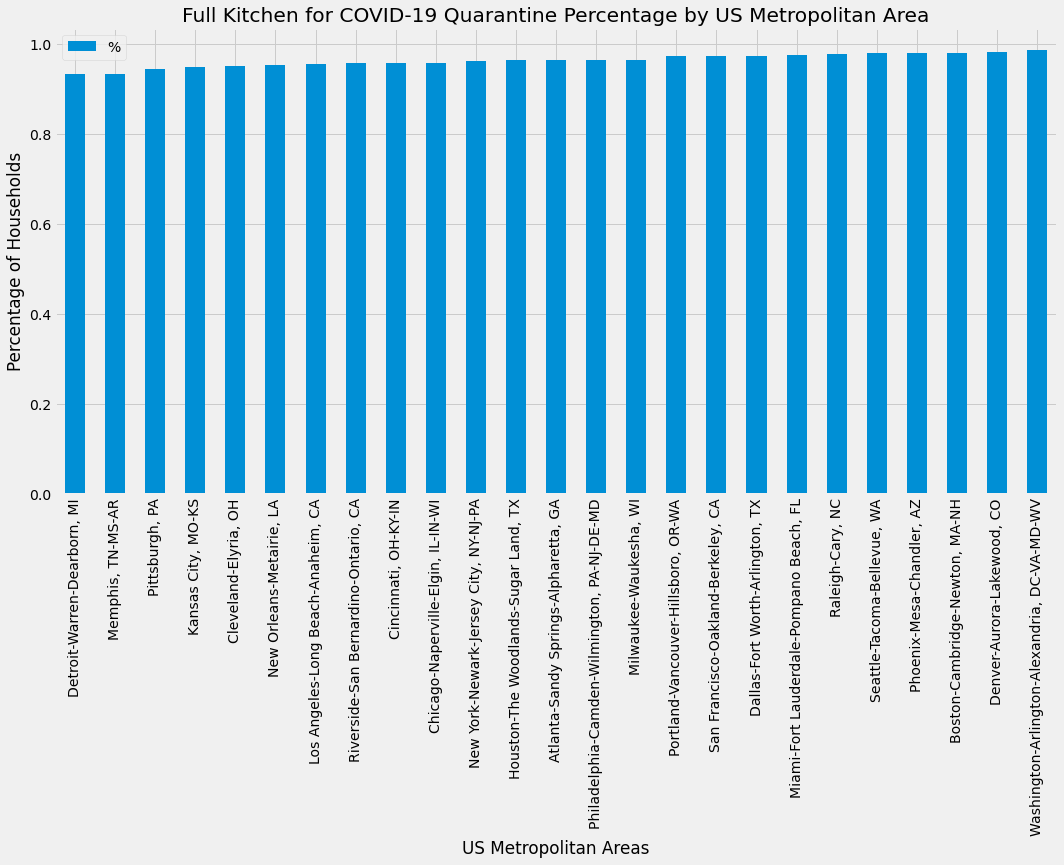

In [277]:
Table_3.plot(kind='bar', figsize=(16,8))
plt.legend('%')
plt.ylabel('Percentage of Households')
plt.xlabel('US Metropolitan Areas', )
plt.title("Full Kitchen for COVID-19 Quarantine Percentage by US Metropolitan Area");

Text(0.5, 1.0, 'Household Resources for COVID-19 Quarantine Percentage by US Metropolitan Area')

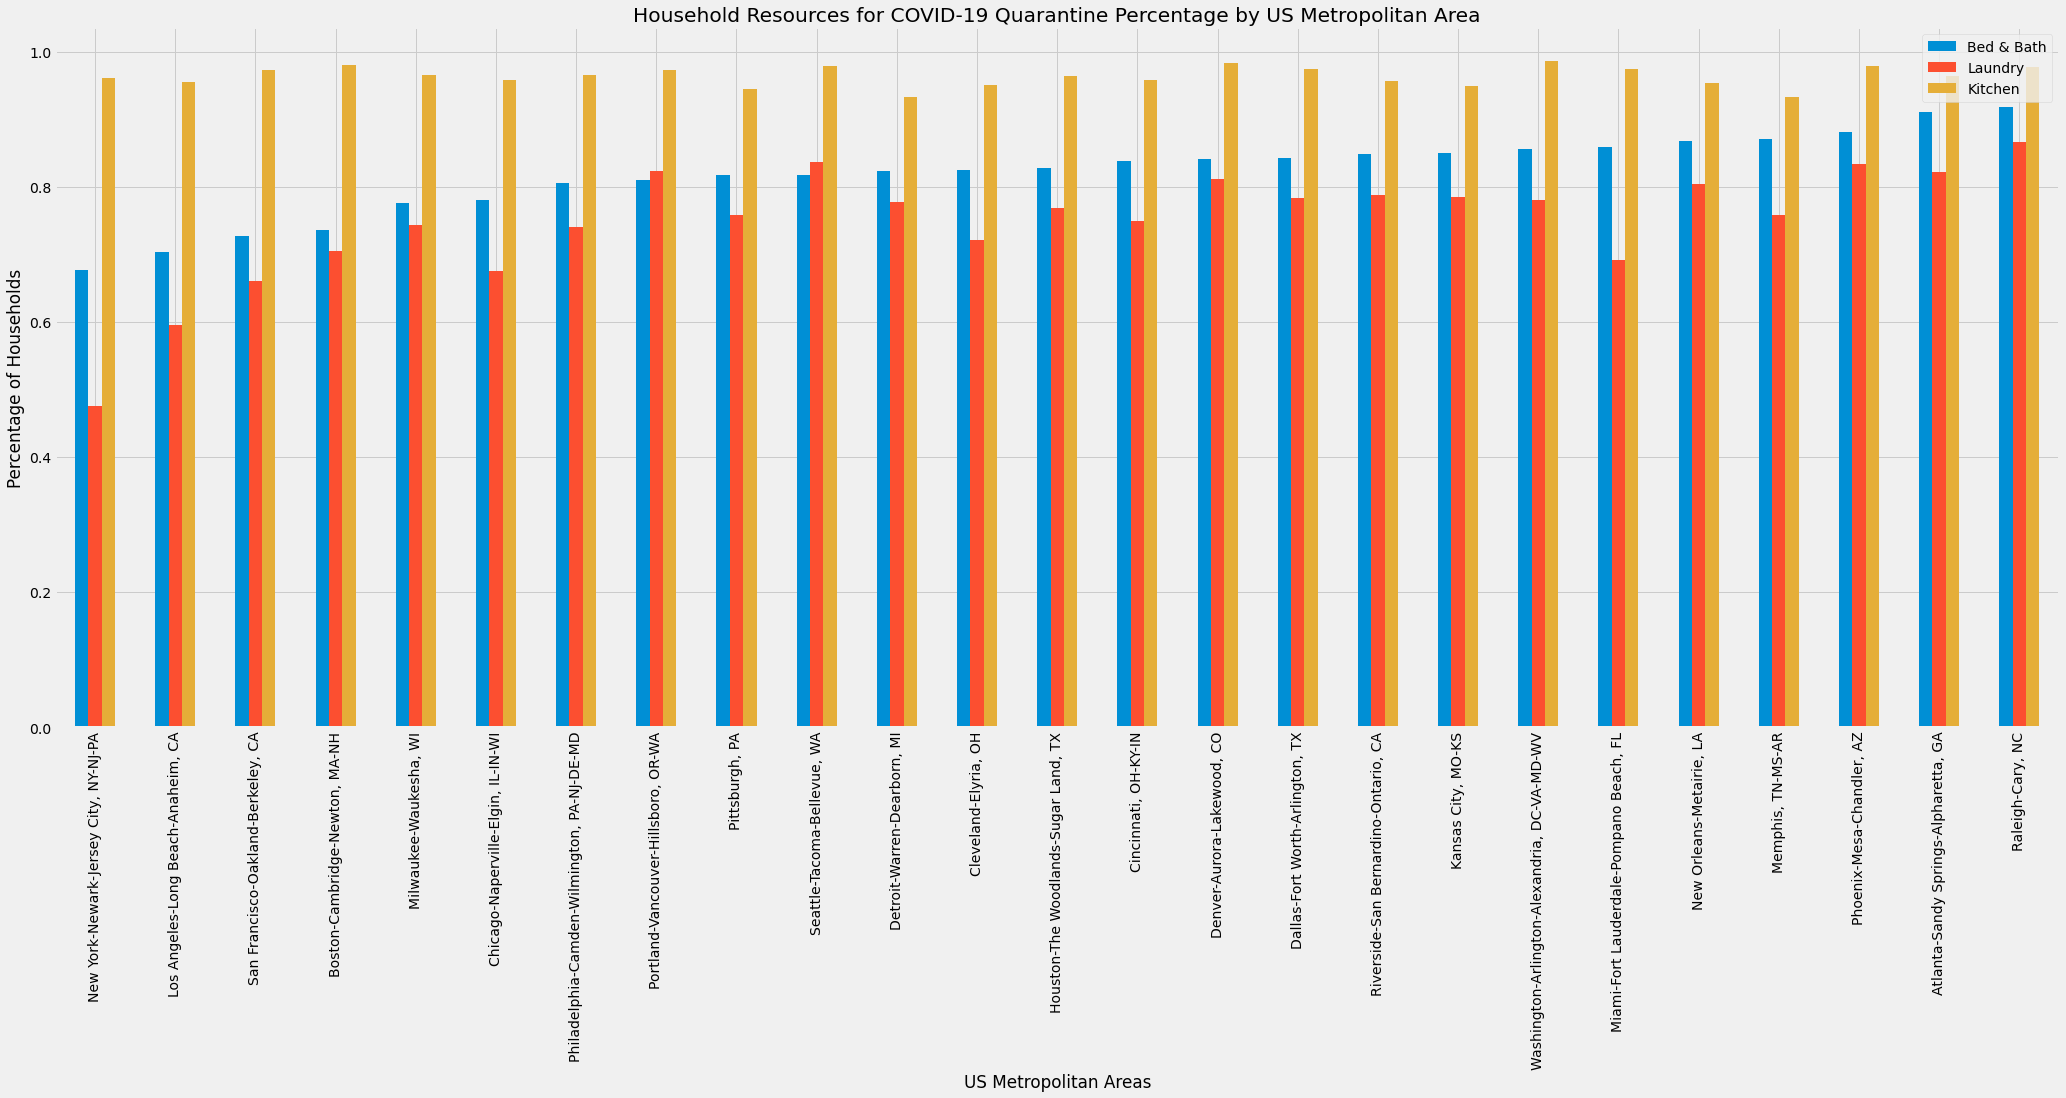

In [278]:
table_4=pd.concat([Table_1, Table_2, Table_3], axis='columns')
table_4.reset_index(inplace=True)
table_4.rename(columns={'index':'Metropolitan Areas', 'mean': 'Bed & Bath', 'mean':'Laundry', 'mean':'Kitchen' }, inplace=True)
#table_4.columns
table_4.plot(kind='bar', x='Metropolitan Areas', y=['Bed & Bath', 'Laundry', 'Kitchen'], figsize=(32,12))
plt.ylabel('Percentage of Households')
plt.xlabel('US Metropolitan Areas' )
plt.title("Household Resources for COVID-19 Quarantine Percentage by US Metropolitan Area")

To simplify the data, the chart will be converted from a broad national comparision to solely the US Metropolitan Areas within the Western States Pact that followed similar public health policies throughout the pandemic.

Text(0.5, 1.0, 'Households With Complete Resources for COVID-19 Quarantine by US Metropolitan Area')

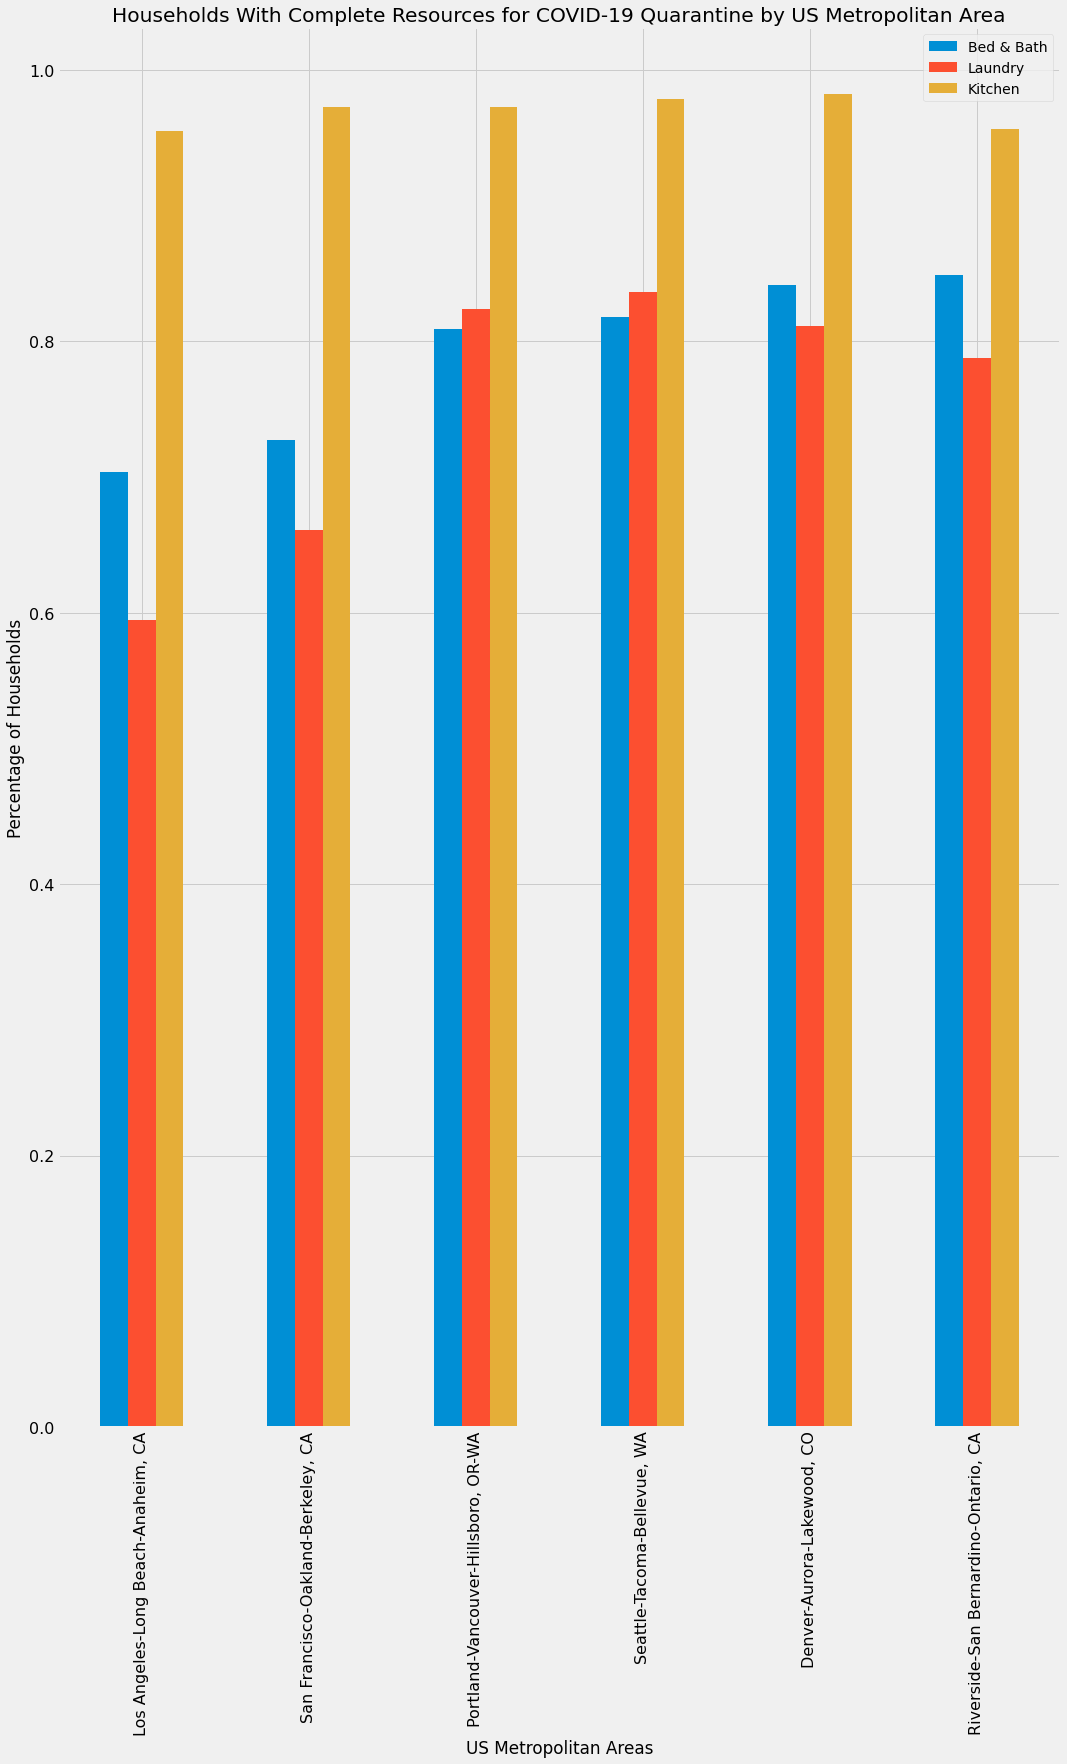

In [279]:
t_4=table_4[(table_4['Metropolitan Areas']=='Los Angeles-Long Beach-Anaheim, CA')| 
        (table_4['Metropolitan Areas']=='San Francisco-Oakland-Berkeley, CA')|
       (table_4['Metropolitan Areas']=='Seattle-Tacoma-Bellevue, WA')|
        (table_4['Metropolitan Areas']=='Portland-Vancouver-Hillsboro, OR-WA')|
        (table_4['Metropolitan Areas']=='Denver-Aurora-Lakewood, CO')|
        (table_4['Metropolitan Areas']=='Riverside-San Bernardino-Ontario, CA')
       ].plot(kind='bar', x='Metropolitan Areas', y=['Bed & Bath', 'Laundry', 'Kitchen'], figsize=( 16,24));
plt.ylabel('Percentage of Households')
plt.xlabel('US Metropolitan Areas' )
plt.setp(t_4.get_xticklabels(), rotation='vertical', fontsize=16)
plt.setp(t_4.get_yticklabels(), rotation='horizontal', fontsize=16)

plt.title('Households With Complete Resources for COVID-19 Quarantine by US Metropolitan Area')

Now by crosswalking the COVID-19 Case Rate dataset to the CBSA table, we can look at the relationship between the percentage of households that can feasibly quarantine and COVID case rates.

In [288]:
cbsa['FIPS State Code']=cbsa['FIPS State Code'].astype(str)
cbsa['FIPS County Code']=cbsa['FIPS County Code'].astype(str)
cbsa['countyFIPS']=cbsa['FIPS State Code']+cbsa['FIPS County Code']

In [289]:
covid_label=covid.merge(cbsa, left_on='countyFIPS', right_on='countyFIPS' )

In [290]:
covid_cleaned=covid_label.loc[:, ('CBSA Title', 'County Name', 'State', '2021-06-07')]

In [291]:
covid_cleaned.rename(columns={ 'CBSA Title':'Metropolitan Areas', 'County Name':'County Name', 'State':'State', '2021-06-07':'Total Cases' }, inplace=True)
covid_cleaned['Total Cases']=covid_cleaned['Total Cases'].apply(pd.to_numeric)
covid_cleaned.rename(columns={ 'CBSA Title':'Metropolitan Areas', 'County Name':'County Name', 'State':'State', '2021-06-07':'Total Cases' }, inplace=True)

Text(0.5, 1.0, 'COVID Cases vs Household Feasibility for Quarantine by US Metropolitan Area')

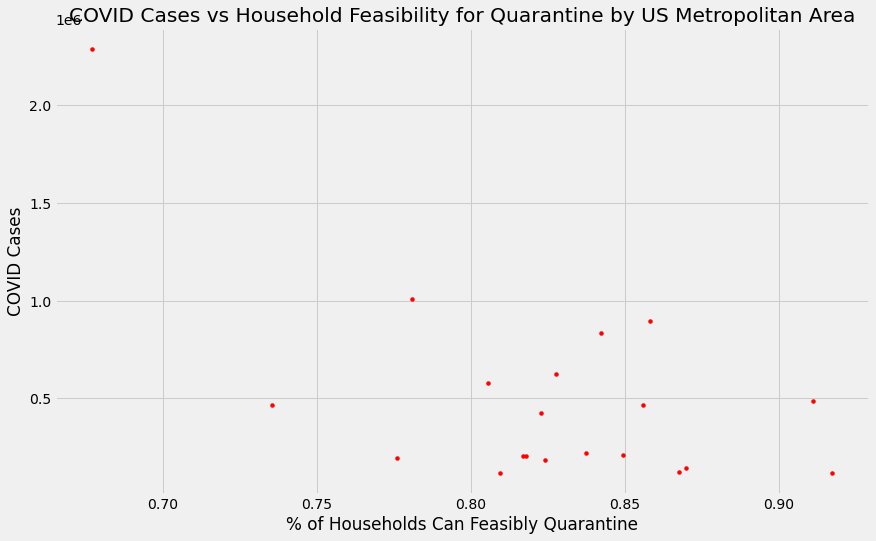

In [292]:
table_5= pd.DataFrame(covid_cleaned.groupby('Metropolitan Areas', as_index=True)['Total Cases'].agg(['sum']).sort_values('sum', ascending=True))
table_5.rename(columns={'sum':'Cases'})
table_6=pd.merge(table_4, table_5, left_on='Metropolitan Areas', right_on='Metropolitan Areas' )
table_6.columns=['Metropolitan Areas', '% of Households Can Feasibly Quarantine', 'Kitchen', 'Laundry', 'COVID Cases']
table_6.plot(kind='scatter', x='% of Households Can Feasibly Quarantine', y='COVID Cases', figsize=(13, 8), s=15, c='red', alpha=1);
plt.title('COVID Cases vs Household Feasibility for Quarantine by US Metropolitan Area')

Text(0.5, 1.0, 'COVID Cases vs Households With Full Kitchen for Quarantine by US Metropolitan Area')

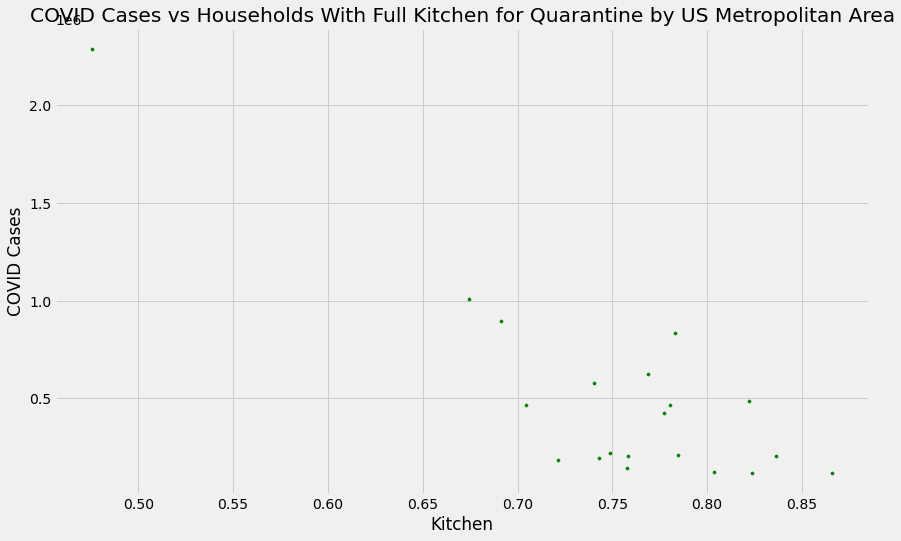

In [293]:
table_6.plot(kind='scatter', x='Kitchen', y='COVID Cases', figsize=(13, 8), s=10, c='green', alpha=1);
plt.title('COVID Cases vs Households With Full Kitchen for Quarantine by US Metropolitan Area')

Text(0.5, 1.0, 'COVID Cases vs Households With Laundry Access for Quarantine by US Metropolitan Area')

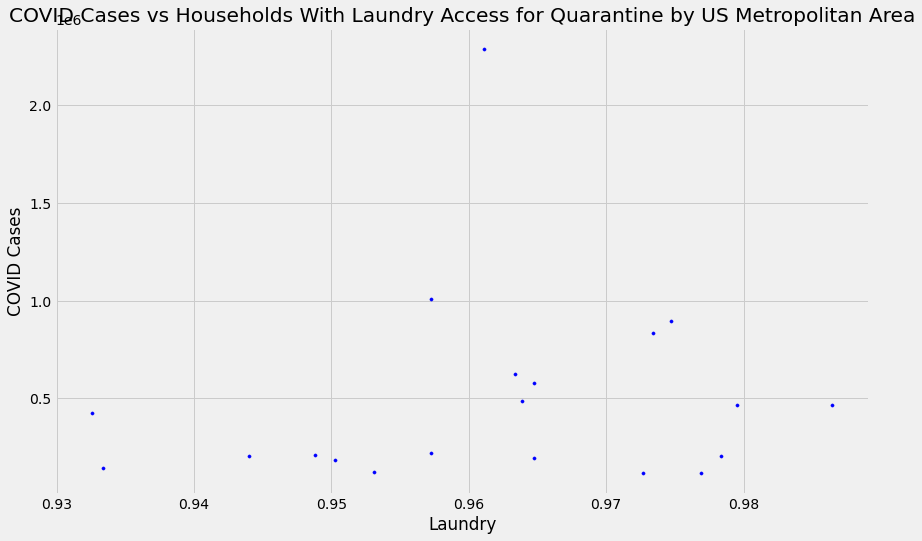

In [295]:
table_6.plot(kind='scatter', x='Laundry', y='COVID Cases', figsize=(13, 8), s=10, c='blue', alpha=1);
plt.title('COVID Cases vs Households With Laundry Access for Quarantine by US Metropolitan Area')